(https://www.kaggle.com/c/ashrae-energy-prediction/)

# ASRAE - Modeling

In [19]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly as plt
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from math import sqrt

import glob

import pandas_profiling as ppf
import sweetviz as sv
import missingno as msno

import pprint
import datetime
from math import sqrt

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from prophet import Prophet

import xgboost as xgb

import pmdarima as pm
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima
from pmdarima.arima import ndiffs
from pmdarima.arima import ADFTest

print("pmdarima version: %s" % pm.__version__)

#import tools as tl

sns.set(rc={'figure.figsize':(30,20)})

pd.options.display.float_format = '{:.2f}'.format
pd.set_option("precision", 2)

plt.rcParams.update({'font.size': 22})
sns.set(font_scale = 2)

import pprint
pp = pprint.PrettyPrinter(indent=4)

import warnings
warnings.filterwarnings('ignore')

pmdarima version: 1.8.2


In [20]:
print(xgb.__version__)

1.4.2


In [21]:
pd.options.plotting.backend = "matplotlib"

In [22]:
pwd

'G:\\My Drive\\Code\\Springboard_Capstone_Energy'

In [23]:
# Drop Specific columns
def building_meter_drop(df):
    return df.drop(columns=['precip_depth_1_hr','wind_direction','wind_speed','dew_temperature','year_built','floor_count','cloud_coverage'],axis=1)

In [24]:
# Interpolate Missing Data
def building_meter_interp(df):
    df['sea_level_pressure'] = df['sea_level_pressure'].interpolate(method='time')
    df['meter_reading'] = df['meter_reading'].interpolate(method='time')
    df['air_temperature'] = df['air_temperature'].interpolate(method='time')
    return df

In [25]:
# Aggregate remaining Data
def building_meter_agg(df,resamp_str):
    df_samp = df
    agg_dict={'meter_reading':'median', 
              'air_temperature':'median',
                  'building_id': 'max',
                  'site_id': 'max',
                  'square_feet': 'max',
                  'day_of_week':'max',
                  'weekend':'max',
                  'month':'max',
                  'season':'max'
                  }

    # Resample Dataframe
    df = df.resample(resamp_str).agg(agg_dict)
    
    return df

## See Statistics written for each file (building-meter) combo

In [26]:
# See Building Statistics for missing data
df_stats = pd.read_csv('.//data_clean//building_reading_stats.csv')
# Keep only data that has at least 50 % of it

In [27]:
df_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   file_name                     2375 non-null   object 
 1   building                      2375 non-null   int64  
 2   meter                         2375 non-null   int64  
 3   len_train                     2375 non-null   int64  
 4   len_zero                      2375 non-null   int64  
 5   per_data                      2375 non-null   float64
 6   category                      2375 non-null   object 
 7   corr_meter_to_airtemp         2375 non-null   float64
 8   corr_meter_to_airtemp_wknd    2373 non-null   float64
 9   corr_meter_to_airtemp_wkdy    2375 non-null   float64
 10  corr_meter_to_airtemp_winter  2325 non-null   float64
 11  corr_meter_to_airtemp_spring  2342 non-null   float64
 12  corr_meter_to_airtemp_summer  2339 non-null   float64
 13  cor

In [28]:
# Modeling Choices
# Buildings with 1
df_stats.sort_values(['building','meter'],axis=0,inplace=True)
df_stats.reset_index(drop=True,inplace=True)

In [29]:
df_stats[(df_stats['building'] == 1148) & df_stats['meter'] == 1]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,site_id,floor_count,bldg_size,meter_name
1686,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,13,-1,XXL,CWater


In [30]:
# Examine building choices
df_stats[df_stats['building'] == 1148]

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,site_id,floor_count,bldg_size,meter_name
1685,1148_0.pkl,1148,0,8663,0,100.00,Office,-0.02,0.15,-0.04,-0.20,-0.11,-0.08,-0.08,861524,13,-1,XXL,Elec
1686,1148_1.pkl,1148,1,8784,0,100.00,Office,0.78,0.79,0.79,0.21,0.74,0.45,0.76,861524,13,-1,XXL,CWater
1687,1148_2.pkl,1148,2,8784,2,99.98,Office,-0.88,-0.86,-0.88,-0.83,-0.85,-0.43,-0.44,861524,13,-1,XXL,Steam


# First Pass 
## No Hypertuning on Prophet or XGBoost

In [31]:
## Train till end of September, Test on October

In [32]:

output_vis_folder = '.\\visualization\\models\\run_1\\'
output_data_folder = '.\\results\\'

model_pass = 1

# Control Variables that will run these specific models if True
ARIMA = True
FBProphet = True
xgboost = True

# Show Visualizations
quiet_mode = True

resample = True
backfill = 'mean'
exogen = True

thresh = 50

# Dictionary to hold all the results, will turn into a dataframe
stats_all = {}
stats_list = []

stats = {}

# For each file in the directory
direct = '.\\data_clean\\buildings_by_meter\\'

files = df_stats['file_name']

bld_mtr = [
           '1073_2', # Elec
            '1073_1',
            '1073_0',
#             '1099_2', # Education 
            '1130_0',
            '1048_0',
            '1156_0',
            '1156_2',
            '1140_1',
            '1169_1',
            '1178_0',
            '107_0',
            '1180_2',
            '119_0',
            '1198_2',
            '120_0',
            '109_0',
            '1138_0',
            '1079_2',
            '126_0',
            '1179_1', # Entertainment
            '1183_0',
            '1196_0',
            '743_0',
            '663_0', # Food
            '1105_0',
            '1105_2',
            '670_0',
            '1209_2',
            '1154_2', # Lodging Residential
            '1154_0',
            '134_0',
            '1184_0',
            '135_0',
            '1124_0',
            '1091_0'
            '1175_0', # Manufacturing
            '1171_0',
            '1081_0',
            '1145_2',
            '1148_1', # Office
            '1164_1',
            '1151_1',
            '1149_0',
            '1188_0',
            '141_0',
            '146_0',
            '1204_2',
            '1210_1',
            '1133_2',
            '155_0',
            '1164_1',
            '1109_2',
            '684_0',
            '1108_0',
            '1205_0',
            '1212_1',
            '1220_0',
            '1047_0',
            '678_0',
            '1104_0'
            '1052_2',
            '1034_0',
            '1197_0',
            '1118_0',
            '1199_0'
          ]

for num,file in enumerate(files):  

    # Get only files from the list
    if file.split('.pkl')[0] not in bld_mtr:
        continue
    else:
        print('')
        print('###########################################################')
        print('File: ' + file)
        
    # Temporary dictionary that represents raw calculations
    stats = {}
    
    # Screen results
    if df_stats.iloc[num]['per_data'] < 80:
        stats['status'] = 'FAIL: Length < 80% data present'
        print('not enough data')
        continue
    
    # Catch exception if file not readable
    try:
        df = pd.read_pickle(direct + file)
    except FileNotFoundError:
        continue
    
    print('Length on load: ' + str(len(df)))
    stats['Len_load'] = len(df)
    
    # Screen minimum length
    if len(df) < 20000:
        stats['status'] = 'FAIL: Length < 20k'
        continue

    # Load key variables in dictionary
    stats['building'] = df.iloc[0]['building_id']
    stats['square_feet'] = df.iloc[0]['square_feet']   
    stats['meter'] = bldg_meter = df.iloc[0]['meter']
    stats['file_name'] = file
 
    # Process Columns
    df = building_meter_drop(df) # Drop poorly correlated columns
    df = building_meter_interp(df) # Time series linear interpolation due to standard time deltas
    df = building_meter_agg(df,'1D') # aggregate remaining columns
    
    print('Length after agg: ' + str(len(df)))
    stats['Len_agg-clean'] = len(df)
    
    # Find out how many lingering NA columns are left
    b4_NA = len(df)
    df.dropna(how='any',inplace=True)
    tot = b4_NA - len(df)
    print('Dropped N/A cols: ' + str(tot))
    if tot > 100:
        stats['status'] = 'FAIL: Drop over 100 Rows'
        continue
    
    print('Length after blank drop: ' + str(len(df)))
    stats['Len_blank'] = len(df)
    
    # Keep track of Models
    model_ctr = 1 # Initialize Model Counter
    model_prefixes = []


    df_train = df.loc['2016-01-01':'2016-09-30']
    df_test = df.loc['2016-10-01':'2016-10-31']
       
    X_train = df_train.drop(labels=['meter_reading'],axis=1)
    X_train.fillna(method='ffill')

    X_test = df_test.drop(labels=['meter_reading'],axis=1)
    X_test.fillna(method='ffill')

    y_train = df_train['meter_reading']
    y_train.fillna(method='ffill')

    y_test = df_test['meter_reading']
    y_test.fillna(method='ffill')
    
    # Get rid of constants
    X_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    X_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    
    #######################################    ARIMA   ##################################################
    if ARIMA:
        print()
        # Keep track of model prefix column names by building prefix to number iterations
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'ARIMA_Exogen'
        stats[model_prefix + '_' + 'Description'] = 'ARIMA_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        print('ARIMA Model......',end=' ')

        # Try building model
        try:
            model = pm.auto_arima(y_train,X=X_train,trace=False,n_fits=10,seasonal=True,m=7,error_action='ignore')
            stats[model_prefix + '_' + 'Status'] = 'PASS'
        except ValueError as ve:
            print('Model will not converge')
            stats[model_prefix + '_' + 'Status'] = 'FAIL'
            continue

        # Create the Series
        preds, conf_int = model.predict(X=X_test,n_periods=y_test.shape[0], return_conf_int=True)
                
        predict = pd.Series(preds,index=y_test.index)

        # Keep each slice data here
        df_result = pd.concat([predict,y_test],axis=1)
        df_result.columns = ['meter_predict_ARIMA','meter_actual']

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error
        
        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range
        
        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error
        
        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error
        
        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

        print('RMSE: ' + str(RMSE_error)) 
        print('RMSE_pct_range: ' + str(RMSE_pct_range))
        print('MAPE: ' + str(MAPE_error))
        print('MedianAPE: ' + str(MedAPE_error))
            
        # Create Graph
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_ARIMA'],label="ARIMA", color='orange', linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red', linestyle='dashed')
        plt.legend(loc = 'upper right')      
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'ARIMA_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ARIMA_Exogen.jpg')
        
        # Add to Models DF
        df_models = pd.DataFrame(data=df_result[['meter_actual','meter_predict_ARIMA']],index=df_result.index)
          
         ######################################    PROPHET   ##################################################
    if FBProphet:   
        print()
        print('Prophet......',end=' ')
        model_ctr += 1 # Increment Model Counter
        model_prefix = 'Model_' + str(model_ctr) # Build string for keys
        model_prefixes.append(model_prefix)

        # Need renaming for Prophet - data prep
        df_prophet_train = df_train.reset_index()
        df_prophet_test = df_test.reset_index()

        # Get rid of constants
        df_prophet_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
        df_prophet_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)

        # Timestamp must be ds column
        df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})
        df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})


        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'Prophet_Exogen'          
        stats[model_prefix + '_' + 'Len_Train'] = len(df_prophet_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(df_prophet_test)

        # Initialize Prophet Model
        m = Prophet(daily_seasonality=True)
        m.add_regressor('air_temperature')
        m.add_regressor('day_of_week')
        m.add_regressor('weekend')
        m.add_regressor('month')
        m.add_regressor('season')
        m.fit(df_prophet_train)
        predicts = m.predict(df_prophet_test)


        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(predicts['yhat'],df_prophet_test['y'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error

        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_prophet_test['y'])) \
                                              - (np.min(df_prophet_test['y']))) \
                                              * 100   
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

        # MAPE
        MAPE_error = mean_absolute_percentage_error(predicts['yhat'],df_prophet_test['y'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error

        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(predicts['yhat'],df_prophet_test['y'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error


        MedAPE_pct_range = MedAPE_error / ((np.max(df_prophet_test['y'])) \
                                              - (np.min(df_prophet_test['y']))) \
                                              * 100 

        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

        print('RMSE: ' + str(RMSE_error)) 
        print('RMSE_pct_range: ' + str(RMSE_pct_range))
        print('MAPE: ' + str(MAPE_error))
        print('MedianAPE: ' + str(MedAPE_error))

        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_prophet_test['ds'],predicts['yhat'],label="Prophet", color='blue', linestyle='solid')
        plt.plot(df_prophet_test['ds'],df_prophet_test['y'],label="Actual",linewidth=7.0,color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + \
                  model_prefix + '_' + 'Prophet_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')

        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_Prophet_Exogen.jpg')
        
        df_models['meter_predict_Prophet'] = pd.Series(predicts['yhat'].values, index=df_models.index)

#       ######################################    XGBOOST   ##################################################
    if xgboost:
        print()
        print('XGBoost......',end=' ')
        model_ctr += 1
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)

        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'XGBoost'
        stats[model_prefix + '_' + 'Description'] = 'XGBoost_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        # Instantiate Model
        gbm_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 1000, seed = 123)
        gbm_model.fit(X_train,y_train)
        predict = gbm_model.predict(X_test)

        predict = pd.Series(predict,index=y_test.index)

        df_result = pd.concat([predict,y_test],axis=1,ignore_index=True)
        df_result.columns = ['meter_predict_XGBoost','meter_actual']
        df_result.sort_index(inplace=True)             

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error

        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error

               # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error

        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                               - (np.min(df_result['meter_actual']))) \
                               * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

        print('RMSE: ' + str(RMSE_error)) 
        print('RMSE_pct_range: ' + str(RMSE_pct_range))
        print('MAPE: ' + str(MAPE_error))
        print('MedianAPE: ' + str(MedAPE_error))

        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_XGBoost'],label="XGBoost",color='green',linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'XGBoost')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_XGBoost.jpg')

        # Apppend to Models Dataframe
        df_models = pd.concat([df_models,df_result['meter_predict_XGBoost']],axis=1)
        df_models.to_csv(output_data_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ModelError_1.csv',float_format="{:,.2f}".format)
        
    
    # VISUALIZE ALL MODELS AT ONCE
    plt.figure(figsize=(20,10))
    plt.plot(df_models['meter_actual'],label='Actual',linewidth=7.0,color='red',linestyle='dashed')
    plt.plot(df_models['meter_predict_ARIMA'],label='ARIMA',color='orange',linestyle='solid')
    plt.plot(df_models['meter_predict_Prophet'],label='FBP',color='blue',linestyle='solid')
    plt.plot(df_models['meter_predict_XGBoost'],label='XGBoost',color='green',linestyle='solid')
    plt.legend(loc = 'upper right')
    plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + '_' + 'All')
    plt.xlabel('Date')
    plt.ylabel('Meter Reading')
    plt.xticks(rotation='45')
    plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ALL.jpg')
    
    
    stats_list.append(stats)
    # Write dictionary and file every 10 buildings to save results
    if stats['building'] % 10 == 0:
#         df_results = pd.DataFrame(stats_list)
        df_results.to_csv(output_data_folder + 'Model_Results_1.csv',float_format="{:,.2f}".format)
            
df_results = pd.DataFrame(stats_list)
# df_results.to_csv(output_data_folder + 'Model_Results_FirstPass.csv',float_format="{:,.2f}".format)
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])
df_stats.to_csv(output_data_folder + 'AllResults_FirstPass.csv',float_format="{:,.2f}".format)



###########################################################
File: 107_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 13.900541958218138
RMSE_pct_range: 24.82239635396096
MAPE: 0.18855333540436958
MedianAPE: 13.176349988856288


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 129.71803900292048
RMSE_pct_range: 231.639355362358
MAPE: 2.775637056965708
MedianAPE: 120.88639275036293

XGBoost...... RMSE: 21.00260443186126
RMSE_pct_range: 37.50465077118083
MAPE: 0.29922008095919905
MedianAPE: 17.829574499511722

###########################################################
File: 109_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 38.514174090896695
RMSE_pct_range: 52.589846509041735
MAPE: 0.13308889490531076
MedianAPE: 37.43680797829393


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 15.462402871720824
RMSE_pct_range: 21.11340598309665
MAPE: 0.05509736669146417
MedianAPE: 11.471272579768595

XGBoost...... RMSE: 15.197492471571344
RMSE_pct_range: 20.75167948599898
MAPE: 0.054006897997821844
MedianAPE: 12.674628784179674

###########################################################
File: 119_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 34.9372097276464
RMSE_pct_range: 30.945269909341356
MAPE: 0.05950131270995232
MedianAPE: 31.578865879791465


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 45.75897040004781
RMSE_pct_range: 40.530531798093705
MAPE: 0.07917241517123422
MedianAPE: 42.75308263684116

XGBoost...... RMSE: 20.540581700009522
RMSE_pct_range: 18.193606465907454
MAPE: 0.030483254558867797
MedianAPE: 10.737499999999955

###########################################################
File: 120_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 52.857595249857155
RMSE_pct_range: 103.13677121923348
MAPE: 0.3311054461622089
MedianAPE: 52.52777898822313


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 61.971018690881095
RMSE_pct_range: 120.91906086025578
MAPE: 0.4127934457124862
MedianAPE: 59.986335625822704

XGBoost...... RMSE: 66.80310632231793
RMSE_pct_range: 130.34752453135206
MAPE: 0.45633332457486814
MedianAPE: 68.47902221679686

###########################################################
File: 126_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 7.53870951563683
RMSE_pct_range: 23.856675682395014
MAPE: 0.04931784358242849
MedianAPE: 4.89785413457615


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 9.296686514263149
RMSE_pct_range: 29.4198940324783
MAPE: 0.057044773347218636
MedianAPE: 5.844890668946221

XGBoost...... RMSE: 13.249357993610591
RMSE_pct_range: 41.928348081046146
MAPE: 0.09747468662059813
MedianAPE: 9.170845031738281

###########################################################
File: 134_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 24.141919285906162
RMSE_pct_range: 76.39847875286759
MAPE: 0.6110673373395116
MedianAPE: 25.617556163327713


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 17.541229846863033
RMSE_pct_range: 55.51022103437667
MAPE: 0.3649411164418559
MedianAPE: 17.94303839660156

XGBoost...... RMSE: 15.116251751437044
RMSE_pct_range: 47.83623971973746
MAPE: 0.2769684016014821
MedianAPE: 13.912321472167974

###########################################################
File: 135_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 4.433292748260915
RMSE_pct_range: 71.5047217461438
MAPE: 0.11645644648266441
MedianAPE: 4.559010444467766


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 2.226982611898061
RMSE_pct_range: 35.9190743854526
MAPE: 0.057747441833189944
MedianAPE: 1.2957391976246662

XGBoost...... RMSE: 10.19721044074431
RMSE_pct_range: 164.47113614103728
MAPE: 0.22450231416782626
MedianAPE: 9.948316192626947

###########################################################
File: 141_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 15.750534308686493
RMSE_pct_range: 36.41742036690518
MAPE: 0.2485351687407305
MedianAPE: 11.080024984540799


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 15.919291635071847
RMSE_pct_range: 36.807610716929126
MAPE: 0.25445164471397025
MedianAPE: 13.911072277104637

XGBoost...... RMSE: 13.290662038480528
RMSE_pct_range: 30.729854424232432
MAPE: 0.20188765190184005
MedianAPE: 10.274444580078125

###########################################################
File: 146_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.795288209360776
RMSE_pct_range: 35.20172959530933
MAPE: 0.226710548554543
MedianAPE: 1.3998971933521291


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 1.558532663430131
RMSE_pct_range: 30.559463988826096
MAPE: 0.177934598194331
MedianAPE: 1.156890234658838

XGBoost...... RMSE: 1.6639223208167777
RMSE_pct_range: 32.6259278591525
MAPE: 0.19532441060697306
MedianAPE: 0.8648074150085456

###########################################################
File: 155_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 5.858532573395313
RMSE_pct_range: 13.37564514473816
MAPE: 0.06947562696416207
MedianAPE: 3.7370039981095715


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 8.559253594463993
RMSE_pct_range: 19.541674873205466
MAPE: 0.11598260509634714
MedianAPE: 7.118610887021951

XGBoost...... RMSE: 7.814577115759791
RMSE_pct_range: 17.841500264291767
MAPE: 0.10183707979474743
MedianAPE: 6.221644592285145

###########################################################
File: 663_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 9.872397652247686
RMSE_pct_range: 42.923468053250815
MAPE: 2.5503616124957937
MedianAPE: 7.032019102012777


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 16.545761665101967
RMSE_pct_range: 71.93809419609552
MAPE: 34.04088849410047
MedianAPE: 15.05148602232395

XGBoost...... RMSE: 4.094282601339661
RMSE_pct_range: 17.80122870147679
MAPE: 0.7179302491563885
MedianAPE: 1.7287675857543938

###########################################################
File: 670_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 3.0106359723909897
RMSE_pct_range: 15.599150116015489
MAPE: 0.14255490142468208
MedianAPE: 1.61794547427332


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 2.5284251597498657
RMSE_pct_range: 13.100648496113292
MAPE: 0.11027852962301149
MedianAPE: 1.5801075391912924

XGBoost...... RMSE: 6.3618507124179215
RMSE_pct_range: 32.96295705916022
MAPE: 0.48929543063244035
MedianAPE: 2.7581357955932617

###########################################################
File: 678_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 12.288494121624636
RMSE_pct_range: 22.141430849774117
MAPE: 0.26678699142192774
MedianAPE: 7.340431321441095


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 6.023030304736724
RMSE_pct_range: 10.852306855381485
MAPE: 0.12621306748097788
MedianAPE: 5.859659003781836

XGBoost...... RMSE: 14.51059870636786
RMSE_pct_range: 26.145222894356507
MAPE: 1.1537406022851837
MedianAPE: 3.294536590576172

###########################################################
File: 684_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 23.168594879204736
RMSE_pct_range: 24.323984125149327
MAPE: 0.18002064199202394
MedianAPE: 16.64583947744906


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 27.037818943720712
RMSE_pct_range: 28.386161620704158
MAPE: 0.2139735127720965
MedianAPE: 16.89446177021898

XGBoost...... RMSE: 53.665364980617674
RMSE_pct_range: 56.34159053083221
MAPE: 1.255646436968963
MedianAPE: 36.100494384765625

###########################################################
File: 743_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 11.463341767389974
RMSE_pct_range: 59.8607925190077
MAPE: 0.546548970324739
MedianAPE: 11.699330788947012


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 12.468432959055203
RMSE_pct_range: 65.1093104911499
MAPE: 0.5177289302188577
MedianAPE: 9.609321105795761

XGBoost...... RMSE: 34.537073791318655
RMSE_pct_range: 180.35025478495382
MAPE: 0.8923394025045447
MedianAPE: 20.163422326660157

###########################################################
File: 1034_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.6425316655220765
RMSE_pct_range: 27.675343985207697
MAPE: 0.22215410617863512
MedianAPE: 1.2645669950967253


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 1.4261557427520442
RMSE_pct_range: 24.029582860186085
MAPE: 0.18203217445733583
MedianAPE: 0.9098385071327506

XGBoost...... RMSE: 1.5573504544812753
RMSE_pct_range: 26.24010875284373
MAPE: 0.19865615574388343
MedianAPE: 0.8398554992675784

###########################################################
File: 1047_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 43.73787805364837
RMSE_pct_range: 29.292255695924652
MAPE: 0.25418150435465614
MedianAPE: 32.0315185937996


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 41.042474449798696
RMSE_pct_range: 27.487082352333616
MAPE: 0.23079828777958009
MedianAPE: 27.25425607341569

XGBoost...... RMSE: 48.97051313487927
RMSE_pct_range: 32.79667089811793
MAPE: 0.2767136269383125
MedianAPE: 44.59095520019531

###########################################################
File: 1048_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 28.418367854175532
RMSE_pct_range: 26.634333603574127
MAPE: 0.1832786625386044
MedianAPE: 20.29249060573197


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 28.100413547645047
RMSE_pct_range: 26.336339675341485
MAPE: 0.1841378799408436
MedianAPE: 21.727926888453112

XGBoost...... RMSE: 28.34751425134862
RMSE_pct_range: 26.567928013204174
MAPE: 0.14171204537835336
MedianAPE: 10.313973144531246

###########################################################
File: 1073_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 153.43579275139015
RMSE_pct_range: 40.69914927092577
MAPE: 0.6182513090824739
MedianAPE: 2.2502252341309514


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 155.3755524359531
RMSE_pct_range: 41.213674386194455
MAPE: 0.6586722670244437
MedianAPE: 3.634516816282826

XGBoost...... RMSE: 153.37312913809748
RMSE_pct_range: 40.682527622837526
MAPE: 0.6206259999827968
MedianAPE: 2.86871337890625

###########################################################
File: 1073_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 511.34053460268797
RMSE_pct_range: 52.64589619034621
MAPE: 0.6531741715691376
MedianAPE: 512.899849263238


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 462.9469432288928
RMSE_pct_range: 47.66345530147274
MAPE: 0.6490058156345904
MedianAPE: 470.7184566259847

XGBoost...... RMSE: 128.6298972042278
RMSE_pct_range: 13.243300221544931
MAPE: 0.3536890204303716
MedianAPE: 97.29214013671876

###########################################################
File: 1073_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 423.15252910384464
RMSE_pct_range: 27.260503532206027
MAPE: 0.22877799091847698
MedianAPE: 274.4487818454613


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 411.0802259953588
RMSE_pct_range: 26.48277673419372
MAPE: 0.14856868381003552
MedianAPE: 260.5198448005617

XGBoost...... RMSE: 414.42244860673907
RMSE_pct_range: 26.69809075227582
MAPE: 0.19512751217297902
MedianAPE: 194.38934570312495

###########################################################
File: 1079_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 18.78647447533745
RMSE_pct_range: 28.410547410718262
MAPE: 2.4968733073760094
MedianAPE: 16.050242230051722


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 15.932342538716632
RMSE_pct_range: 24.094279831707574
MAPE: 0.46342762228021783
MedianAPE: 14.052310109936798

XGBoost...... RMSE: 14.633829073515752
RMSE_pct_range: 22.130554364485068
MAPE: 0.25407742676400724
MedianAPE: 9.130050659179688

###########################################################
File: 1081_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.4662149636134831
RMSE_pct_range: 20.577011628846865
MAPE: 0.08278122101754935
MedianAPE: 1.032140268885687


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 2.2900925827617598
RMSE_pct_range: 32.139394888243075
MAPE: 0.1428790274155627
MedianAPE: 1.8496267602749867

XGBoost...... RMSE: 2.0731702628531927
RMSE_pct_range: 29.09508473585283
MAPE: 0.12647765012982132
MedianAPE: 1.493125747680665

###########################################################
File: 1105_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 9.954576698547674
RMSE_pct_range: 32.35314265741805
MAPE: 0.1213346189296007
MedianAPE: 5.724372199385044


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 7.159464568709946
RMSE_pct_range: 23.268812482603778
MAPE: 0.08481929721959212
MedianAPE: 3.9138416411397827

XGBoost...... RMSE: 7.374576578184462
RMSE_pct_range: 23.96794311774854
MAPE: 0.08056576883879883
MedianAPE: 5.587439941406245

###########################################################
File: 1105_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 927.4912928364191
RMSE_pct_range: 72.72217069574162
MAPE: 10.524920289736617
MedianAPE: 945.7863423626488


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 570.2334638974527
RMSE_pct_range: 44.71051708869073
MAPE: 2.745955991215652
MedianAPE: 478.1172881481163

XGBoost...... RMSE: 681.9602765384438
RMSE_pct_range: 53.47072476171555
MAPE: 4.12967192252743
MedianAPE: 582.4728593139648

###########################################################
File: 1108_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 25.48472700069591
RMSE_pct_range: 42.908637382681306
MAPE: 0.28087157244211064
MedianAPE: 27.3295118398066


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 12.495024222635386
RMSE_pct_range: 21.03787352488574
MAPE: 0.1199731332540284
MedianAPE: 11.358936424354056

XGBoost...... RMSE: 25.711621474869762
RMSE_pct_range: 43.290659631387136
MAPE: 0.2880385084401624
MedianAPE: 26.408456604003902

###########################################################
File: 1109_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 121.95832542036051
RMSE_pct_range: 15.610635681385634
MAPE: 0.11697015078803293
MedianAPE: 87.09811988175943


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 146.00605567819474
RMSE_pct_range: 18.688739244429577
MAPE: 0.13341559219275115
MedianAPE: 111.43589553517086

XGBoost...... RMSE: 152.39010233855947
RMSE_pct_range: 19.505895648015965
MAPE: 0.13353347787459224
MedianAPE: 80.00006103515625

###########################################################
File: 1118_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.4461170824080787
RMSE_pct_range: 14.34639962706427
MAPE: 0.06322516870850071
MedianAPE: 1.215024514468702


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 3.9130024091562756
RMSE_pct_range: 38.81946834480432
MAPE: 0.1551901902355897
MedianAPE: 3.7985180542666512

XGBoost...... RMSE: 4.0625938550963685
RMSE_pct_range: 40.30351046722588
MAPE: 0.1519391988764431
MedianAPE: 2.879023666381837

###########################################################
File: 1124_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 58.92954723108944
RMSE_pct_range: 196.4776688930397
MAPE: 0.27836112044336
MedianAPE: 59.16669433512777


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 78.56752630294517
RMSE_pct_range: 261.9528766810426
MAPE: 0.3481525575539644
MedianAPE: 76.24839727973347

XGBoost...... RMSE: 43.97864080528557
RMSE_pct_range: 146.62968294363864
MAPE: 0.12796337017970025
MedianAPE: 8.79128039550784

###########################################################
File: 1130_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 259.49462767639284
RMSE_pct_range: 44.78678420372674
MAPE: 0.2404907562669579
MedianAPE: 204.83770903930963


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 180.28967000822
RMSE_pct_range: 31.11661546569209
MAPE: 0.14636689641125933
MedianAPE: 145.76394006980127

XGBoost...... RMSE: 160.71302327293125
RMSE_pct_range: 27.737836256978117
MAPE: 0.10297801623111233
MedianAPE: 78.81636718749996

###########################################################
File: 1133_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 803.3795932672496
RMSE_pct_range: 86.41370707087842
MAPE: 1.4211367230280891
MedianAPE: 785.4334540377438


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 167.60165454938416
RMSE_pct_range: 18.02769251571859
MAPE: 0.1048966336654369
MedianAPE: 124.16762534669954

XGBoost...... RMSE: 231.80833527297617
RMSE_pct_range: 24.933938761627655
MAPE: 0.1210692689440142
MedianAPE: 161.1697998046875

###########################################################
File: 1138_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 26.48547826047321
RMSE_pct_range: 77.93858091804078
MAPE: 0.2715796899916851
MedianAPE: 23.47887167085551


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 8.589400939850197
RMSE_pct_range: 25.275953622747583
MAPE: 0.10170947392782168
MedianAPE: 5.400768257206394

XGBoost...... RMSE: 9.817295011131886
RMSE_pct_range: 28.88926656700327
MAPE: 0.09123400176903027
MedianAPE: 4.622325317382817

###########################################################
File: 1140_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 349.88028337200547
RMSE_pct_range: 33.56977258502827
MAPE: 0.49026727065833026
MedianAPE: 378.7481193771138


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 361.47670049587543
RMSE_pct_range: 34.68240768952067
MAPE: 0.5061063937368634
MedianAPE: 353.0036710748607

XGBoost...... RMSE: 142.3788633868517
RMSE_pct_range: 13.660747095398762
MAPE: 0.25294272403259416
MedianAPE: 41.018294921875

###########################################################
File: 1145_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 42.096432260457746
RMSE_pct_range: 25.658777758755193
MAPE: 0.12189125968671491
MedianAPE: 31.307061145247985


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 98.57178792091806
RMSE_pct_range: 60.081851685130985
MAPE: 0.20096497168303462
MedianAPE: 83.71704515568723

XGBoost...... RMSE: 71.46739022809031
RMSE_pct_range: 43.56107594855027
MAPE: 0.1502584879490954
MedianAPE: 45.89245678710938

###########################################################
File: 1148_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 448.0777439764276
RMSE_pct_range: 35.21611863701332
MAPE: 0.49045490089653826
MedianAPE: 400.580465338209


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 747.8093423086216
RMSE_pct_range: 58.77315459344204
MAPE: 0.6244183138344365
MedianAPE: 732.510742118078

XGBoost...... RMSE: 251.65581377764806
RMSE_pct_range: 19.778578857855553
MAPE: 0.3458752730837396
MedianAPE: 132.73880932617186

###########################################################
File: 1149_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 59.48856573009558
RMSE_pct_range: 16.80565279347973
MAPE: 0.11060612713403074
MedianAPE: 52.41253473564598


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 75.14889965853463
RMSE_pct_range: 21.229732133791543
MAPE: 0.13859380539138505
MedianAPE: 67.62974897312063

XGBoost...... RMSE: 38.663572892784096
RMSE_pct_range: 10.922545766854888
MAPE: 0.07211268840425172
MedianAPE: 24.583592773437545

###########################################################
File: 1151_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 258.7975421035583
RMSE_pct_range: 48.864658546186774
MAPE: 0.5536819820435117
MedianAPE: 270.10753441403233


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 181.39700609291498
RMSE_pct_range: 34.250335965261776
MAPE: 0.5054697758644319
MedianAPE: 169.57222362217374

XGBoost...... RMSE: 95.33163808112415
RMSE_pct_range: 17.999969805040656
MAPE: 0.3186749297047568
MedianAPE: 29.891517089843745

###########################################################
File: 1154_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 71.07762568960145
RMSE_pct_range: 31.31676489373906
MAPE: 0.2093688687623819
MedianAPE: 61.73988630759101


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 119.68456257269821
RMSE_pct_range: 52.732955991909805
MAPE: 0.47992607055359765
MedianAPE: 116.39071876095508

XGBoost...... RMSE: 80.67790224373881
RMSE_pct_range: 35.54664174800741
MAPE: 0.21234814461879317
MedianAPE: 35.78117797851564

###########################################################
File: 1154_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 8626.100215478762
RMSE_pct_range: 34.251576276785585
MAPE: 1.029158295041163
MedianAPE: 5477.794685196457


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 10295.795988446123
RMSE_pct_range: 40.881421826712796
MAPE: 1.977819090430656
MedianAPE: 8130.148712259359

XGBoost...... RMSE: 8650.278430210596
RMSE_pct_range: 34.34758049021193
MAPE: 1.0560069366810891
MedianAPE: 5987.9248046875

###########################################################
File: 1156_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 499.1861733697874
RMSE_pct_range: 61.61320392841802
MAPE: 0.3250488239109165
MedianAPE: 458.8241197274409


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 1083.2329647536524
RMSE_pct_range: 133.70052521448918
MAPE: 0.5337754868945951
MedianAPE: 1064.5641371873523

XGBoost...... RMSE: 423.87316377051366
RMSE_pct_range: 52.31752214384757
MAPE: 0.2699441505205325
MedianAPE: 393.49871582031255

###########################################################
File: 1156_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 3705.234843750932
RMSE_pct_range: 37.023377644502496
MAPE: 0.6132305535159291
MedianAPE: 3154.085070042027


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 2192.5138229295544
RMSE_pct_range: 21.90799522303352
MAPE: 0.1782033452466159
MedianAPE: 1005.7164601109444

XGBoost...... RMSE: 2117.5418589823203
RMSE_pct_range: 21.158861780479977
MAPE: 0.19575897097185466
MedianAPE: 1332.6673437499994

###########################################################
File: 1164_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 332.1623840133885
RMSE_pct_range: 59.03099371740793
MAPE: 0.685204613448983
MedianAPE: 357.40454363443973


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 276.08163058776677
RMSE_pct_range: 49.06447504321049
MAPE: 0.6824447373224445
MedianAPE: 261.0430177084524

XGBoost...... RMSE: 98.42162670277207
RMSE_pct_range: 17.491223290696958
MAPE: 0.3492509170450041
MedianAPE: 19.281811059570316

###########################################################
File: 1169_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 131.1899255102919
RMSE_pct_range: 27.68826894091455
MAPE: 0.3719846181407203
MedianAPE: 134.33096158734725


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 178.99083881712454
RMSE_pct_range: 37.776883124608794
MAPE: 0.44325665349464766
MedianAPE: 182.0187159090907

XGBoost...... RMSE: 59.42423799076135
RMSE_pct_range: 12.541773133090414
MAPE: 0.1872344350112061
MedianAPE: 36.333898925781256

###########################################################
File: 1171_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 59.75597203417375
RMSE_pct_range: 31.9601925625361
MAPE: 0.3409901130517443
MedianAPE: 46.02688099235857


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 51.38305905531615
RMSE_pct_range: 27.481980561221665
MAPE: 0.2739466374570456
MedianAPE: 47.122432996571206

XGBoost...... RMSE: 58.10200434383986
RMSE_pct_range: 31.075575944718324
MAPE: 0.3218726511315666
MedianAPE: 34.916318237304694

###########################################################
File: 1178_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 18.46629204325778
RMSE_pct_range: 34.722497143341855
MAPE: 0.12390009716897431
MedianAPE: 16.720381081349785


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 19.807448494118244
RMSE_pct_range: 37.24429745521224
MAPE: 0.13068629144101998
MedianAPE: 19.25808513241691

XGBoost...... RMSE: 13.16247366426132
RMSE_pct_range: 24.74963317681817
MAPE: 0.0849956982121857
MedianAPE: 7.682430969238283

###########################################################
File: 1179_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 133.03195246897567
RMSE_pct_range: 35.107105705058636
MAPE: 0.43094881543616276
MedianAPE: 109.36962787254691


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 158.2512428962591
RMSE_pct_range: 41.762471415365646
MAPE: 0.4484933899950263
MedianAPE: 141.5090707520327

XGBoost...... RMSE: 91.71398843107454
RMSE_pct_range: 24.203303242002328
MAPE: 0.43079754076298543
MedianAPE: 58.44963232421878

###########################################################
File: 1180_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 489.5183352550846
RMSE_pct_range: 22.652398669832696
MAPE: 0.3188046886187926
MedianAPE: 296.6061725697814


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 477.22874513329646
RMSE_pct_range: 22.083699450869805
MAPE: 0.23984481565271545
MedianAPE: 376.0835075269856

XGBoost...... RMSE: 479.41340561368213
RMSE_pct_range: 22.184794336588716
MAPE: 0.25519062830808387
MedianAPE: 234.0394287109375

###########################################################
File: 1183_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 66.5370157774811
RMSE_pct_range: 41.47365598975335
MAPE: 0.21819599688135713
MedianAPE: 53.85759634654846


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 36.98828144377154
RMSE_pct_range: 23.05542625147822
MAPE: 0.09380695997915672
MedianAPE: 24.693197654928667

XGBoost...... RMSE: 39.207701768495255
RMSE_pct_range: 24.43882876763691
MAPE: 0.09751412721717252
MedianAPE: 25.778237792968753

###########################################################
File: 1184_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 21.827702803585744
RMSE_pct_range: 70.15395900104694
MAPE: 0.284831265381675
MedianAPE: 22.882964388842936


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 17.502312546867515
RMSE_pct_range: 56.25220976688152
MAPE: 0.235502429649646
MedianAPE: 16.872031958668146

XGBoost...... RMSE: 11.402332933098347
RMSE_pct_range: 36.64695292504451
MAPE: 0.14131870617704045
MedianAPE: 6.459650604248047

###########################################################
File: 1188_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 7.6713561246405915
RMSE_pct_range: 45.989965076829776
MAPE: 0.16022106826001384
MedianAPE: 3.9499251409781664


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 5.403534514050205
RMSE_pct_range: 32.39431979886817
MAPE: 0.11997262852895589
MedianAPE: 2.3919133573197726

XGBoost...... RMSE: 4.3259389877776835
RMSE_pct_range: 25.93410861651439
MAPE: 0.1036586392529245
MedianAPE: 2.30164324951172

###########################################################
File: 1196_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 16.781725033405795
RMSE_pct_range: 25.475297775931192
MAPE: 0.15352877867669523
MedianAPE: 15.91316671200289


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 18.590765930488473
RMSE_pct_range: 28.221490759684663
MAPE: 0.16630034720232267
MedianAPE: 18.518948069494215

XGBoost...... RMSE: 10.743820115870175
RMSE_pct_range: 16.309528141952008
MAPE: 0.09632218675225462
MedianAPE: 8.409125091552738

###########################################################
File: 1197_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 26.8411349929209
RMSE_pct_range: 26.455545418447024
MAPE: 0.10012364853490667
MedianAPE: 19.8278314920575


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 27.723390541977906
RMSE_pct_range: 27.325126818596846
MAPE: 0.10241027366214775
MedianAPE: 27.28129145354805

XGBoost...... RMSE: 31.596259391283013
RMSE_pct_range: 31.14235950154794
MAPE: 0.11866937407786973
MedianAPE: 27.548701538085936

###########################################################
File: 1198_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 831.3362939400505
RMSE_pct_range: 48.14979440014772
MAPE: 0.9876225613869443
MedianAPE: 494.97073300647537


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 598.1482721828969
RMSE_pct_range: 34.643881827787695
MAPE: 0.47768672607995954
MedianAPE: 524.1572983526264

XGBoost...... RMSE: 852.9512681764861
RMSE_pct_range: 49.40170241022182
MAPE: 0.9624903551743386
MedianAPE: 448.39401611328117

###########################################################
File: 1199_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 2.908245517854861
RMSE_pct_range: 54.38514292388711
MAPE: 0.14050573370238906
MedianAPE: 2.7561092551156428


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 2.5606148244989306
RMSE_pct_range: 47.88433519399593
MAPE: 0.12434644507457084
MedianAPE: 2.4864551456707105

XGBoost...... RMSE: 1.9545567283000076
RMSE_pct_range: 36.5508504590932
MAPE: 0.09117223475267516
MedianAPE: 1.3812908325195323

###########################################################
File: 1204_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 44.435256530837215
RMSE_pct_range: 26.765727616299213
MAPE: 0.23372637357127096
MedianAPE: 33.659401012603865


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 76.40536907170768
RMSE_pct_range: 46.0230334346538
MAPE: 0.25363185351992545
MedianAPE: 46.10696356327088

XGBoost...... RMSE: 50.88753101777114
RMSE_pct_range: 30.65227705712487
MAPE: 0.16113074236949496
MedianAPE: 17.77668688964843

###########################################################
File: 1205_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 6.742259877758757
RMSE_pct_range: 32.748493674755956
MAPE: 0.23258736342392222
MedianAPE: 5.141358304832465


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 10.883869329419648
RMSE_pct_range: 52.865112344179366
MAPE: 0.2226828591659869
MedianAPE: 6.854870274034177

XGBoost...... RMSE: 4.552633622681263
RMSE_pct_range: 22.113044602104445
MAPE: 0.12408927495632395
MedianAPE: 3.1625934143066416

###########################################################
File: 1209_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 314.89084340747587
RMSE_pct_range: 24.31730358186582
MAPE: 0.097472928838013
MedianAPE: 143.06801520066483


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 369.5546416190051
RMSE_pct_range: 28.538690782787047
MAPE: 0.119189349078437
MedianAPE: 137.84091632585887

XGBoost...... RMSE: 286.9071257412021
RMSE_pct_range: 22.156273586593986
MAPE: 0.09487441597889502
MedianAPE: 110.93873046874978

###########################################################
File: 1210_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 14.497923291786124
RMSE_pct_range: 50.741894279995805
MAPE: 0.43978493491818027
MedianAPE: 13.103065403226083


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 12.770787358897392
RMSE_pct_range: 44.69701825533965
MAPE: 1.0096933993427408
MedianAPE: 6.619380980235077

XGBoost...... RMSE: 6.322987043728628
RMSE_pct_range: 22.130089506573334
MAPE: 0.3071158841511221
MedianAPE: 3.4102075408935555

###########################################################
File: 1212_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 385.7050496040238
RMSE_pct_range: 54.91323190877203
MAPE: 0.25654409851303506
MedianAPE: 381.6237315236374


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 216.01293095292223
RMSE_pct_range: 30.75398723685164
MAPE: 0.163442577669646
MedianAPE: 206.7792915499275

XGBoost...... RMSE: 107.5076549073768
RMSE_pct_range: 15.305977435239226
MAPE: 0.0806156338807958
MedianAPE: 65.01945703125

###########################################################
File: 1220_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 185.75980113184136
RMSE_pct_range: 29.34631103265782
MAPE: 0.30617559580245934
MedianAPE: 189.7843298698018


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... RMSE: 362.40993059963415
RMSE_pct_range: 57.253477231881945
MAPE: 0.4718898490967042
MedianAPE: 352.89088525454224

XGBoost...... RMSE: 152.16376430102227
RMSE_pct_range: 24.038813176315386
MAPE: 0.19595946585185092
MedianAPE: 47.944792968749994


# Second Pass
## Hyperparameter Tuning on Prophet and XGBoost

In [18]:
# Data is daily
# # data_sizes = [360] # Start with one year # Train on whole year
output_vis_folder = '.\\visualization\\models\\run_2\\'
output_data_folder = '.\\results\\'

# Median Average Percentage of Range
# tune_on = 'RMSE'
# tune_on = 'RMSEpctRange'
# tune_on = 'MAPE'
# tune_on = 'MedAE'
tune_on = 'MedAEpctRange'

model_pass = 2

# Control Variables that will run these specific models if True
ARIMA = True
FBProphet = True
xgboost = True

# Show Visualizations
quiet_mode = True

resample = True
backfill = 'mean'
exogen = True

thresh = 50

# Dictionary to hold all the results, will turn into a dataframe
stats_all = {}
stats_list = []

stats = {}

# For each file in the directory
direct = '.\\data_clean\\buildings_by_meter\\'

files = df_stats['file_name']
# bl = df_stats['building']

bld_mtr = ['1073_2', # Elec
           '1073_1',
           '1073_0',
#            '1099_2', # issues 
           '1130_0',
           '1048_0',
           '1156_0',
           '1156_2',
           '1140_1',
           '1169_1',
           '1178_0',
           '107_0',
           '1180_2',
           '119_0',
           '1198_2',
           '120_0',
           '109_0',
           '1138_0',
           '1079_2',
           '126_0',
           '1179_1', # Entertainment
           '1183_0',
           '1196_0',
           '743_0',
           '663_0', # Food
           '1105_0',
           '1105_2',
           '670_0',
           '1209_2',
           '1154_2', # Lodging Residential
           '1154_0',
           '134_0',
           '1184_0',
           '135_0',
           '1124_0',
           '1091_0'
           '1175_0', # Manufacturing
           '1171_0',
           '1081_0',
           '1145_2',
           '1148_1', # Office
           '1164_1',
           '1151_1',
           '1149_0',
           '1188_0',
           '141_0',
           '146_0',
           '1204_2',
           '1210_1',
           '1133_2',
           '155_0',
           '1164_1',
           '1109_2',
           '684_0',
           '1108_0',
           '1205_0',
           '1212_1',
           '1220_0',
           '1047_0',
           '678_0',
           '1104_0'
           '1052_2',
           '1034_0',
           '1197_0',
           '1118_0',
           '1199_0'
          ]

for num,file in enumerate(files):  

    # Get only files from the list
    if file.split('.pkl')[0] not in bld_mtr:
        continue
    else:
        print('')
        print('###########################################################')
        print('File: ' + file)
        
    # Temporary dictionary that represents raw calculations
    stats = {}
    
    # Screen results
    if df_stats.iloc[num]['per_data'] < 80:
        stats['status'] = 'FAIL: Length < 80% data present'
        print('not enough data')
        continue
    
    # Catch exception if file not readable
    try:
        df = pd.read_pickle(direct + file)
    except FileNotFoundError:
        continue
    
    print('Length on load: ' + str(len(df)))
    stats['Len_load'] = len(df)
    
    # Screen minimum length
    if len(df) < 20000:
        stats['status'] = 'FAIL: Length < 20k'
        continue

    # Load key variables in dictionary
    stats['building'] = df.iloc[0]['building_id']
    stats['square_feet'] = df.iloc[0]['square_feet']   
    stats['meter'] = bldg_meter = df.iloc[0]['meter']
    stats['file_name'] = file
 
    # Process Columns
    df = building_meter_drop(df) # Drop poorly correlated columns
    df = building_meter_interp(df) # Time series linear interpolation due to standard time deltas
    df = building_meter_agg(df,'1D') # aggregate remaining columns
    
    print('Length after agg: ' + str(len(df)))
    stats['Len_agg-clean'] = len(df)
    
    # Find out how many lingering NA columns are left
    b4_NA = len(df)
    df.dropna(how='any',inplace=True)
    tot = b4_NA - len(df)
    print('Dropped N/A cols: ' + str(tot))
    if tot > 100:
        stats['status'] = 'FAIL: Drop over 100 Rows'
        continue
    
    print('Length after blank drop: ' + str(len(df)))
    stats['Len_blank'] = len(df)
    
    # Keep track of Models
    model_ctr = 4 # Initialize Model Counter
    model_prefixes = []
  
    df_train = df.loc['2016-01-01':'2016-09-30']
    df_test = df.loc['2016-10-01':'2016-10-31']
       
    X_train = df_train.drop(labels=['meter_reading'],axis=1)
    X_train.fillna(method='ffill')

    X_test = df_test.drop(labels=['meter_reading'],axis=1)
    X_test.fillna(method='ffill')

    y_train = df_train['meter_reading']
    y_train.fillna(method='ffill')

    y_test = df_test['meter_reading']
    y_test.fillna(method='ffill')
    
    # Get rid of constants
    X_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    X_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
    
   
    #   ######################################    ARIMA   ##################################################
    if ARIMA:
        print()
        # Keep track of model prefix column names by building prefix to number iterations
        model_prefix = 'Model_' + str(model_ctr)
        model_prefixes.append(model_prefix)
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'ARIMA_Exogen'
        stats[model_prefix + '_' + 'Description'] = 'ARIMA_Exogen, with daily aggregation'
        stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

        print('ARIMA Model......',end=' ')

        # Try building model
        try:
            model = pm.auto_arima(y_train,X=X_train,trace=False,n_fits=10,seasonal=True,m=7,error_action='ignore')
            stats[model_prefix + '_' + 'Status'] = 'PASS'
        except ValueError as ve:
            print('Model will not converge')
            stats[model_prefix + '_' + 'Status'] = 'FAIL'
            continue

        # Create the Series
        preds, conf_int = model.predict(X=X_test,n_periods=y_test.shape[0], return_conf_int=True)
                
        predict = pd.Series(preds,index=y_test.index)

        # Keep each slice data here
        df_result = pd.concat([predict,y_test],axis=1)
        df_result.columns = ['meter_predict_ARIMA','meter_actual']

        # Error Calculations ------------------------
        # RMSE
        RMSE_error = (mean_squared_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'],squared=False))
        stats[model_prefix + '_' + 'RMSE'] = RMSE_error
        
        # RMSE relative to the range of the test range
        RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100      
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range
        
        # MAPE
        MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MAPE'] = MAPE_error
        
        # Median Absolute Percentage
        MedAPE_error = median_absolute_error(df_result['meter_predict_ARIMA'],df_result['meter_actual'])
        stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error
        
        MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                                       - (np.min(df_result['meter_actual']))) \
                                       * 100  
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

        print('RMSE: ' + str(RMSE_error)) 
        print('RMSE_pct_range: ' + str(RMSE_pct_range))
        print('MAPE: ' + str(MAPE_error))
        print('MedianAPE: ' + str(MedAPE_error))
            
        # Create Graph
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_result['meter_predict_ARIMA'],label="ARIMA", color='orange', linestyle='solid')
        plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red', linestyle='dashed')
        plt.legend(loc = 'upper right')      
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'ARIMA_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ARIMA_Exogen.jpg')
        
        # Add to Models DF
        df_models = pd.DataFrame(data=df_result[['meter_actual','meter_predict_ARIMA']],index=df_result.index)
          
         ######################################    PROPHET   ##################################################
    if FBProphet:           
        print()
        print('Prophet......',end=' ')
        model_ctr += 1 # Increment Model Counter
        model_prefix = 'Model_' + str(model_ctr) # Build string for keys
        model_prefixes.append(model_prefix)
        
        # Set parameter grid
        params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.5],
          'n_changepoints' : [100,200]}

        grid = ParameterGrid(params_grid)
        print('Tuning Prophet....')

        # Need renaming for Prophet - data prep
        df_prophet_train = df_train.reset_index()
        df_prophet_test = df_test.reset_index()

        # Get rid of constants
        df_prophet_train.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)
        df_prophet_test.drop(labels=['site_id','building_id','square_feet'],axis=1,inplace=True)

        # Timestamp must be ds column
        df_prophet_train = df_prophet_train.rename(columns={'timestamp':'ds','meter_reading':'y'})
        df_prophet_test = df_prophet_test.rename(columns={'timestamp':'ds','meter_reading':'y'})
        
        # Populate DataFrame with statistics
        stats[model_prefix + '_' + 'Type'] = 'Prophet_Exogen'      
        stats[model_prefix + '_' + 'Len_Train'] = len(df_prophet_train)
        stats[model_prefix + '_' + 'Len_Test'] = len(df_prophet_test)
      
        # Initialize Error List Metrics
        errors_RMSE = []
        errors_RMSE_pct_range = []
        errors_MAPE = []
        errors_MedAE = []
        errors_MedAE_pct_range = []
        errors = []
                
        params = []

        tuning_iter = 0
        
        # Step through grid 
        for val in grid:
            print('Tuning Iteration: ' + str(tuning_iter))
            # Initialize Prophet Model
            m = Prophet(daily_seasonality=True,
                       n_changepoints = val['n_changepoints'],
                       seasonality_mode = val['seasonality_mode'],
                       changepoint_prior_scale = val['changepoint_prior_scale'])
            m.add_regressor('air_temperature')
            m.add_regressor('day_of_week')
            m.add_regressor('weekend')
            m.add_regressor('month')
            m.add_regressor('season')
            m.fit(df_prophet_train)
            
            predicts = m.predict(df_prophet_test)
            
            # Evaluate error metrics
            
            RMSE_error = (mean_squared_error(predicts['yhat'],df_prophet_test['y'],squared=False))
            errors_RMSE.append(RMSE_error)
            
            RMSE_pct_range = RMSE_error / ((np.max(df_prophet_test['y'])) \
                                                  - (np.min(df_prophet_test['y']))) \
                                                  * 100 
            errors_RMSE_pct_range.append(RMSE_pct_range)
            
            
            MAPE_error = mean_absolute_percentage_error(predicts['yhat'],df_prophet_test['y'])
            errors_MAPE.append(MAPE_error)
            
            MedAE_error = median_absolute_error(predicts['yhat'],df_prophet_test['y'])
            errors_MedAE.append(MedAE_error)
            
            MedAPE_pct_range = MedAPE_error / ((np.max(df_prophet_test['y'])) \
                                                  - (np.min(df_prophet_test['y']))) \
                                                  * 100
            
            errors_MedAE_pct_range.append(MedAPE_pct_range)
            tuning_iter += 1

        # Assign error list to whatever we named as our metric to tune on
        if tune_on == 'RMSE':
            errors = errors_RMSE
        elif tune_on == 'RMSEpctRange':
            errors = errors_RMSE_pct_range
        elif tune_on == 'MAPE':
            errors = errors_MAPE
        elif tune_on == 'MedAE':
            errors = errors_MedAE
        elif tune_on == 'MedAEpctRange':
            errors = errors_MedAE_pct_range
        else:
            errors = errors_RMSE

        
        # Min value of errors
        min_value = min(errors)
        # What index is the min value at
        min_index = errors.index(min_value)
        print('Error Metric: ' + tune_on)
        error = errors[min_index]
        print(error)
        
        # Pick the index matching the lowest 
        stats[model_prefix + '_' + 'RMSE'] = errors_RMSE[min_index]
        stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = errors_RMSE_pct_range[min_index]
        stats[model_prefix + '_' + 'MAPE'] = errors_MAPE[min_index]
        stats[model_prefix + '_' + 'MedianAE'] = errors_MedAE[min_index]
        stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = errors_MedAE_pct_range[min_index]
    
        best_parameter = grid[min_index]
        
        print('RMSE: ' + str(errors_RMSE[min_index])) 
        print('RMSE_pct_range: ' + str(errors_RMSE_pct_range[min_index]))
        print('MAPE: ' + str(errors_MAPE[min_index]))
        print('MedianAPE: ' + str(errors_MedAE_pct_range[min_index]))
        
        print('Best Parameters: ')
        print(best_parameter)
        
        plt.ioff()
        plt.figure(figsize=(20,10))
        plt.plot(df_prophet_test['ds'],predicts['yhat'],label="Prophet", color='blue', linestyle='solid')
        plt.plot(df_prophet_test['ds'],df_prophet_test['y'],label="Actual",linewidth=7.0,color='red',linestyle='dashed')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + \
                  model_prefix + '_' + 'Prophet_Exogen')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')

        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_Prophet_Exogen.jpg')

        df_models['meter_predict_Prophet'] = pd.Series(predicts['yhat'].values, index=df_models.index)
        
#             ######################################    XGBOOST   ##################################################
        if xgboost:
            print('XGBoost......',end=' ')

            model_ctr += 1
            model_prefix = 'Model_' + str(model_ctr)
            model_prefixes.append(model_prefix)

            # Populate DataFrame with statistics
            stats[model_prefix + '_' + 'Type'] = 'XGBoost'
            stats[model_prefix + '_' + 'Description'] = 'XGBoost_Exogen, with daily aggregation'
            stats[model_prefix + '_' + 'Len_Train'] = len(X_train)
            stats[model_prefix + '_' + 'Len_Test'] = len(X_test)

            params_grid = {# Parameters that we are going to tune.
                'learning_rate': [0.01,0.1],
                'max_depth': [3,10],
                'min_child_weight': [1,5],
                'subsample': [0.5,0.7],
                'colsample_bytree': [0.5,0.7],
                'n_estimators' : [100,500],
                'objective': ['reg:squarederror'],
            }

            num_boost_round = 30

            num_boost_round = ''
            early_stopping_rounds = ''

            # Instantiate Model
            gbm_model = xgb.XGBRegressor()
            gsearch = GridSearchCV(estimator = gbm_model,
                                  param_grid = params_grid,
                                  scoring = 'mean_absolute_percentage_error',
                                  cv=5,
                                  n_jobs = -1,
                                  verbose = 1)

#                 print(gsearch.best_params_)

            gbm_model.fit(X_train,y_train)
            predict = gbm_model.predict(X_test)

            predict = pd.Series(predict,index=y_test.index)

            df_result = pd.concat([predict,y_test],axis=1,ignore_index=True)
            df_result.columns = ['meter_predict_XGBoost','meter_actual']
            df_result.sort_index(inplace=True)

            # Error Calculations ------------------------
            # RMSE
            RMSE_error = (mean_squared_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'],squared=False))
            stats[model_prefix + '_' + 'RMSE'] = RMSE_error

            # RMSE relative to the range of the test range
            RMSE_pct_range = RMSE_error / ((np.max(df_result['meter_actual'])) \
                                           - (np.min(df_result['meter_actual']))) \
                                           * 100      
            stats[model_prefix + '_' + 'y_pred_RMSE_pct_Range'] = RMSE_pct_range

            # MAPE
            MAPE_error = mean_absolute_percentage_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
            stats[model_prefix + '_' + 'MAPE'] = MAPE_error

                   # Median Absolute Percentage
            MedAPE_error = median_absolute_error(df_result['meter_predict_XGBoost'],df_result['meter_actual'])
            stats[model_prefix + '_' + 'MedianAPE'] = MedAPE_error

            MedAPE_pct_range = MedAPE_error / ((np.max(df_result['meter_actual'])) \
                                   - (np.min(df_result['meter_actual']))) \
                                   * 100  
            stats[model_prefix + '_' + 'y_pred_MedAPE_pct_Range'] = MedAPE_pct_range

            print('RMSE: ' + str(RMSE_error)) 
            print('RMSE_pct_range: ' + str(RMSE_pct_range))
            print('MAPE: ' + str(MAPE_error))
            print('MedianAPE: ' + str(MedAPE_error))
 
            plt.ioff()
            plt.figure(figsize=(20,10))
            plt.plot(df_result['meter_predict_XGBoost'],label="XGBoost",color='green',linestyle='solid')
            plt.plot(df_result['meter_actual'],label="Actual",linewidth=7.0, color='red',linestyle='dashed')
            plt.legend(loc = 'upper right')
            plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + ' ' + model_prefix + '_' + 'XGBoost')
            plt.xlabel('Date')
            plt.ylabel('Meter Reading')
            plt.xticks(rotation='45')
            plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_XGBoost.jpg')

            # Apppend to Models Dataframe
            df_models = pd.concat([df_models,df_result['meter_predict_XGBoost']],axis=1)
            df_models.to_csv(output_data_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ModelError_2.csv',float_format="{:,.2f}".format)
        
        # VISUALIZE ALL MODELS AT ONCE
        plt.figure(figsize=(20,10))
        plt.plot(df_models['meter_actual'],label='Actual',linewidth=7.0,color='red',linestyle='dashed')
        plt.plot(df_models['meter_predict_ARIMA'],label='ARIMA',color='orange',linestyle='solid')
        plt.plot(df_models['meter_predict_Prophet'],label='FBP',color='blue',linestyle='solid')
        plt.plot(df_models['meter_predict_XGBoost'],label='XGBoost',color='green',linestyle='solid')
        plt.legend(loc = 'upper right')
        plt.title('Bldg ' + str(stats['building']) + ' Meter ' + str(stats['meter']) + '_All')
        plt.xlabel('Date')
        plt.ylabel('Meter Reading')
        plt.xticks(rotation='45')
        plt.savefig(output_vis_folder + str(stats['building']) + '_' + str(stats['meter']) + '_ALL.jpg')
        

        stats_list.append(stats)
        # Write dictionary and file every 10 buildings to save results
        if stats['building'] % 10 == 0:
            df_results = pd.DataFrame(stats_list)
            df_results.to_csv('Model_Results_2.csv',float_format="{:,.2f}".format)
            
df_results = pd.DataFrame(stats_list)
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])
df_stats.to_csv(output_data_folder + 'AllResults_SecondPass.csv',float_format="{:,.2f}".format)



###########################################################
File: 107_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 13.900541958218138
RMSE_pct_range: 24.82239635396096
MAPE: 0.18855333540436958
MedianAPE: 13.176349988856288

Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
23.529196408671943
RMSE: 15.679822227899542
RMSE_pct_range: 27.99968254982061
MAPE: 0.22229396563160955
MedianAPE: 23.529196408671943
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 20.68839792887135
RMSE_pct_range: 36.943567730127405
MAPE: 0.2915797451646767
MedianAPE: 18.095314025878906

###########################################################
File: 109_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 38.514174090896695
RMSE_pct_range: 52.589846509041735
MAPE: 0.13308889490531076
MedianAPE: 37.43680797829393


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
51.11873827854707
RMSE: 16.24337280070084
RMSE_pct_range: 22.179794907763842
MAPE: 0.05784452589976555
MedianAPE: 51.11873827854707
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 15.09994866304804
RMSE_pct_range: 20.618486602100155
MAPE: 0.0539414053055959
MedianAPE: 12.896689941406237

###########################################################
File: 119_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 34.9372097276464
RMSE_pct_range: 30.945269909341356
MAPE: 0.05950131270995232
MedianAPE: 31.578865879791465


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
27.97065179786666
RMSE: 15.698994701679425
RMSE_pct_range: 13.90522117066379
MAPE: 0.025823748813578355
MedianAPE: 27.97065179786666
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 20.477208226564695
RMSE_pct_range: 18.137474071359335
MAPE: 0.030354485686067235
MedianAPE: 10.572399902343705

###########################################################
File: 120_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 52.857595249857155
RMSE_pct_range: 103.13677121923348
MAPE: 0.3311054461622089
MedianAPE: 52.52777898822313


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
102.49322729409391
RMSE: 73.24476254766739
RMSE_pct_range: 142.9166098491071
MAPE: 0.5284655958114265
MedianAPE: 102.49322729409391
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 66.763716147592
RMSE_pct_range: 130.27066565383808
MAPE: 0.4560021001952533
MedianAPE: 68.55844421386718

###########################################################
File: 126_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 7.53870951563683
RMSE_pct_range: 23.856675682395014
MAPE: 0.04931784358242849
MedianAPE: 4.89785413457615


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
15.499538400557425
RMSE: 8.082758605129586
RMSE_pct_range: 25.578350016232847
MAPE: 0.04893704288801766
MedianAPE: 15.499538400557425
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 12.97647162646585
RMSE_pct_range: 41.06478362805645
MAPE: 0.09424018476079174
MedianAPE: 8.730854797363293

###########################################################
File: 134_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 24.141919285906162
RMSE_pct_range: 76.39847875286759
MAPE: 0.6110673373395116
MedianAPE: 25.617556163327713


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
81.06821570673326
RMSE: 22.604629630820725
RMSE_pct_range: 71.53363807221747
MAPE: 0.5391687940566914
MedianAPE: 81.06821570673326
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 15.061494032485319
RMSE_pct_range: 47.66295579900416
MAPE: 0.2774058349274297
MedianAPE: 13.905966186523443

###########################################################
File: 135_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 4.433292748260915
RMSE_pct_range: 71.5047217461438
MAPE: 0.11645644648266441
MedianAPE: 4.559010444467766


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
73.53242652367365
RMSE: 1.5752022938498071
RMSE_pct_range: 25.406488610480764
MAPE: 0.038744805688762624
MedianAPE: 73.53242652367365
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 10.104512259250196
RMSE_pct_range: 162.97600418145478
MAPE: 0.2231612916729111
MedianAPE: 9.73157958984375

###########################################################
File: 141_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 15.750534308686493
RMSE_pct_range: 36.41742036690518
MAPE: 0.2485351687407305
MedianAPE: 11.080024984540799


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
25.61855487755098
RMSE: 13.849597492754855
RMSE_pct_range: 32.022190734693304
MAPE: 0.21726519868113975
MedianAPE: 25.61855487755098
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 13.336058173233061
RMSE_pct_range: 30.834816585509966
MAPE: 0.20333234261340827
MedianAPE: 10.911048889160156

###########################################################
File: 146_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.795288209360776
RMSE_pct_range: 35.20172959530933
MAPE: 0.226710548554543
MedianAPE: 1.3998971933521291


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
27.448964575531942
RMSE: 1.3939151383224697
RMSE_pct_range: 27.331669378871954
MAPE: 0.14399000939714543
MedianAPE: 27.448964575531942
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 1.6854757034927255
RMSE_pct_range: 33.04854320573971
MAPE: 0.19874676192077081
MedianAPE: 0.9090769767761238

###########################################################
File: 155_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 5.858532573395313
RMSE_pct_range: 13.37564514473816
MAPE: 0.06947562696416207
MedianAPE: 3.7370039981095715


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
8.531972598423682
RMSE: 5.387547503370403
RMSE_pct_range: 12.300336765685854
MAPE: 0.06803457720772689
MedianAPE: 8.531972598423682
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 7.860161228127238
RMSE_pct_range: 17.945573580199177
MAPE: 0.10172450463449602
MedianAPE: 6.512317657470703

###########################################################
File: 663_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 9.872397652247686
RMSE_pct_range: 42.923468053250815
MAPE: 2.5503616124957937
MedianAPE: 7.032019102012777


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
30.573996095707727
RMSE: 14.524056928384987
RMSE_pct_range: 63.14807360167386
MAPE: 59.414610145699406
MedianAPE: 30.573996095707727
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 3.969627625044839
RMSE_pct_range: 17.259250543673215
MAPE: 0.9810624235145263
MedianAPE: 1.7097303390502923

###########################################################
File: 670_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 3.0106359723909897
RMSE_pct_range: 15.599150116015489
MAPE: 0.14255490142468208
MedianAPE: 1.61794547427332


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
8.38313717240062
RMSE: 2.5733074744898126
RMSE_pct_range: 13.333199349688146
MAPE: 0.11666666832201845
MedianAPE: 8.38313717240062
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 6.295347999705671
RMSE_pct_range: 32.61838341816409
MAPE: 0.4601011142154861
MedianAPE: 2.9259023666381836

###########################################################
File: 678_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 12.288494121624636
RMSE_pct_range: 22.141430849774117
MAPE: 0.26678699142192774
MedianAPE: 7.340431321441095


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
13.226002380974947
RMSE: 4.797664023775436
RMSE_pct_range: 8.644439682478263
MAPE: 0.08150314908541198
MedianAPE: 13.226002380974947
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 14.336691870661959
RMSE_pct_range: 25.831877244435965
MAPE: 1.6018628947948486
MedianAPE: 3.3206443786621094

###########################################################
File: 684_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 23.168594879204736
RMSE_pct_range: 24.323984125149327
MAPE: 0.18002064199202394
MedianAPE: 16.64583947744906


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
17.47594695795177
RMSE: 23.93337860601318
RMSE_pct_range: 25.126906672979715
MAPE: 0.1854691825006528
MedianAPE: 17.47594695795177
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 53.77590507165132
RMSE_pct_range: 56.4576431198439
MAPE: 1.301907699684566
MedianAPE: 35.02688903808594

###########################################################
File: 743_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 11.463341767389974
RMSE_pct_range: 59.8607925190077
MAPE: 0.546548970324739
MedianAPE: 11.699330788947012


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
61.0931111694361
RMSE: 10.58221227133392
RMSE_pct_range: 55.25959410618236
MAPE: 0.35089881698754866
MedianAPE: 61.0931111694361
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 34.48956001885746
RMSE_pct_range: 180.1021410906395
MAPE: 0.8704261091017644
MedianAPE: 20.083193521118165

###########################################################
File: 1034_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.6425316655220765
RMSE_pct_range: 27.675343985207697
MAPE: 0.22215410617863512
MedianAPE: 1.2645669950967253


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
21.30694178764491
RMSE: 1.348395024574329
RMSE_pct_range: 22.719376993670245
MAPE: 0.17394130212150752
MedianAPE: 21.30694178764491
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 1.5499932257498603
RMSE_pct_range: 26.11614533698164
MAPE: 0.19317181091901858
MedianAPE: 0.8563078117370608

###########################################################
File: 1047_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 43.73787805364837
RMSE_pct_range: 29.292255695924652
MAPE: 0.25418150435465614
MedianAPE: 32.0315185937996


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
21.452239448549953
RMSE: 40.63772028008392
RMSE_pct_range: 27.21600924223133
MAPE: 0.2339593262266377
MedianAPE: 21.452239448549953
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 48.42038794406558
RMSE_pct_range: 32.428239495608686
MAPE: 0.27166768500735033
MedianAPE: 42.34777587890625

###########################################################
File: 1048_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 28.418367854175532
RMSE_pct_range: 26.634333603574127
MAPE: 0.1832786625386044
MedianAPE: 20.29249060573197


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
19.018578660598433
RMSE: 29.060413790096767
RMSE_pct_range: 27.236073497078696
MAPE: 0.17313710635380233
MedianAPE: 19.018578660598433
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 28.378356094027865
RMSE_pct_range: 26.596833681928118
MAPE: 0.1397496542236979
MedianAPE: 9.289359497070308

###########################################################
File: 1073_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 153.43579275139015
RMSE_pct_range: 40.69914927092577
MAPE: 0.6182513090824739
MedianAPE: 2.2502252341309514


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
0.5968767199286343
RMSE: 155.69936300202355
RMSE_pct_range: 41.29956578303012
MAPE: 0.6661479284209553
MedianAPE: 0.5968767199286343
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 153.33374910035042
RMSE_pct_range: 40.67208198948287
MAPE: 0.6198465112160632
MedianAPE: 2.9256591796875

###########################################################
File: 1073_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 511.34053460268797
RMSE_pct_range: 52.64589619034621
MAPE: 0.6531741715691376
MedianAPE: 512.899849263238


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
52.80643796670116
RMSE: 481.5927719413984
RMSE_pct_range: 49.583166915073384
MAPE: 1.1315840817933795
MedianAPE: 52.80643796670116
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 129.50268061047385
RMSE_pct_range: 13.333159056298932
MAPE: 0.35741977502136
MedianAPE: 97.6297255859375

###########################################################
File: 1073_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 423.15252910384464
RMSE_pct_range: 27.260503532206027
MAPE: 0.22877799091847698
MedianAPE: 274.4487818454613


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
17.680650527488158
RMSE: 1100.5207767391043
RMSE_pct_range: 70.89819499625412
MAPE: 1.3148544574491325
MedianAPE: 17.680650527488158
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 405.1374240417506
RMSE_pct_range: 26.099927140949813
MAPE: 0.18885235664135522
MedianAPE: 188.24188476562495

###########################################################
File: 1079_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 18.78647447533745
RMSE_pct_range: 28.410547410718262
MAPE: 2.4968733073760094
MedianAPE: 16.050242230051722


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
24.272578041666122
RMSE: 27.81692086894687
RMSE_pct_range: 42.067177117499995
MAPE: 1.050430868048715
MedianAPE: 24.272578041666122
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 14.039109298383648
RMSE_pct_range: 21.23116718092045
MAPE: 0.2513349807116291
MedianAPE: 7.449825286865234

###########################################################
File: 1081_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.4662149636134831
RMSE_pct_range: 20.577011628846865
MAPE: 0.08278122101754935
MedianAPE: 1.032140268885687


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
14.485162709784397
RMSE: 3.052910338862844
RMSE_pct_range: 42.84485774840846
MAPE: 0.2110567514721235
MedianAPE: 14.485162709784397
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 2.057699951328566
RMSE_pct_range: 28.877972792485668
MAPE: 0.1248040978596245
MedianAPE: 1.4812978210449188

###########################################################
File: 1099_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1416792.4964416015
RMSE_pct_range: 49400.01730967927
MAPE: 1.0024699957695977
MedianAPE: 1473133.9104894968


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
51364.501760442705
RMSE: 42077.76693416672
RMSE_pct_range: 1467.1466852917267
MAPE: 0.9339430013592573
MedianAPE: 51364.501760442705
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 1636541.6717183406
RMSE_pct_range: 57062.12244485149
MAPE: 0.9805626393675319
MedianAPE: 1061610.5

###########################################################
File: 1105_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 9.954576698547674
RMSE_pct_range: 32.35314265741805
MAPE: 0.1213346189296007
MedianAPE: 5.724372199385044


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
18.604651508474713
RMSE: 24.21281123191393
RMSE_pct_range: 78.69350547447526
MAPE: 0.237555242544076
MedianAPE: 18.604651508474713
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 6.816283373909641
RMSE_pct_range: 22.15344710957518
MAPE: 0.07728372772326957
MedianAPE: 5.445375579833986

###########################################################
File: 1105_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 927.4912928364191
RMSE_pct_range: 72.72217069574162
MAPE: 10.524920289736617
MedianAPE: 945.7863423626488


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
74.15663776277444
RMSE: 703.8377462725232
RMSE_pct_range: 55.18608004394917
MAPE: 4.336641212951838
MedianAPE: 74.15663776277444
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 682.1623363865193
RMSE_pct_range: 53.48656774684758
MAPE: 4.112876250350518
MedianAPE: 582.3724869995117

###########################################################
File: 1108_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 25.48472700069591
RMSE_pct_range: 42.908637382681306
MAPE: 0.28087157244211064
MedianAPE: 27.3295118398066


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
46.014701799549776
RMSE: 23.422904385863756
RMSE_pct_range: 39.43714644127044
MAPE: 0.29065570461405793
MedianAPE: 46.014701799549776
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 25.545322359062578
RMSE_pct_range: 43.010661793582706
MAPE: 0.2847036059631774
MedianAPE: 26.398121704101555

###########################################################
File: 1109_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 121.95832542036051
RMSE_pct_range: 15.610635681385634
MAPE: 0.11697015078803293
MedianAPE: 87.09811988175943


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
11.148537939672362
RMSE: 236.81064514722908
RMSE_pct_range: 30.311704380372912
MAPE: 0.25382336083983975
MedianAPE: 11.148537939672362
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 152.05687184318862
RMSE_pct_range: 19.463242226503066
MAPE: 0.13544835482951892
MedianAPE: 82.90362548828125

###########################################################
File: 1118_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 1.4461170824080787
RMSE_pct_range: 14.34639962706427
MAPE: 0.06322516870850071
MedianAPE: 1.215024514468702


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
12.053814627665695
RMSE: 2.850783593814814
RMSE_pct_range: 28.28158327197236
MAPE: 0.11552685952308508
MedianAPE: 12.053814627665695
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 4.002041592092107
RMSE_pct_range: 39.70279357234233
MAPE: 0.1495800747152036
MedianAPE: 2.8245249938964854

###########################################################
File: 1124_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 58.92954723108944
RMSE_pct_range: 196.4776688930397
MAPE: 0.27836112044336
MedianAPE: 59.16669433512777


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
197.26834373062957
RMSE: 47.14594348895883
RMSE_pct_range: 157.1898225884666
MAPE: 0.23785256798612642
MedianAPE: 197.26834373062957
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 43.97689236540257
RMSE_pct_range: 146.62385345048023
MAPE: 0.12567497704907996
MedianAPE: 9.099843627929715

###########################################################
File: 1130_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 259.49462767639284
RMSE_pct_range: 44.78678420372674
MAPE: 0.2404907562669579
MedianAPE: 204.83770903930963


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
35.35341888838619
RMSE: 190.4999530794186
RMSE_pct_range: 32.87883208136322
MAPE: 0.14714353056869012
MedianAPE: 35.35341888838619
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 158.93310444104847
RMSE_pct_range: 27.430635906290718
MAPE: 0.10116563881191155
MedianAPE: 77.73213867187496

###########################################################
File: 1133_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 803.3795932672496
RMSE_pct_range: 86.41370707087842
MAPE: 1.4211367230280891
MedianAPE: 785.4334540377438


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
84.48337123533047
RMSE: 419.2569393469845
RMSE_pct_range: 45.096423468789006
MAPE: 0.3188360998863443
MedianAPE: 84.48337123533047
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 228.98713894879938
RMSE_pct_range: 24.630483166302678
MAPE: 0.11939474998148163
MedianAPE: 160.66827148437505

###########################################################
File: 1138_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 26.48547826047321
RMSE_pct_range: 77.93858091804078
MAPE: 0.2715796899916851
MedianAPE: 23.47887167085551


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
69.0910664926227
RMSE: 9.420440277723442
RMSE_pct_range: 27.721445678579983
MAPE: 0.1380300227214973
MedianAPE: 69.0910664926227
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 9.872732755222522
RMSE_pct_range: 29.05240272264407
MAPE: 0.09111434773355595
MedianAPE: 4.116310302734377

###########################################################
File: 1140_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 349.88028337200547
RMSE_pct_range: 33.56977258502827
MAPE: 0.49026727065833026
MedianAPE: 378.7481193771138


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
36.339539090227454
RMSE: 675.1988945587894
RMSE_pct_range: 64.78293981459205
MAPE: 7.050322230717908
MedianAPE: 36.339539090227454
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 142.36947793579333
RMSE_pct_range: 13.659846594648617
MAPE: 0.24972538218787838
MedianAPE: 44.41385595703116

###########################################################
File: 1145_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 42.096432260457746
RMSE_pct_range: 25.658777758755193
MAPE: 0.12189125968671491
MedianAPE: 31.307061145247985


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
19.082399174246383
RMSE: 42.0631646771274
RMSE_pct_range: 25.63850037463003
MAPE: 0.1179414868654634
MedianAPE: 19.082399174246383
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 70.88037062908255
RMSE_pct_range: 43.20327352629792
MAPE: 0.1480531497584537
MedianAPE: 46.30746166992185

###########################################################
File: 1148_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 448.0777439764276
RMSE_pct_range: 35.21611863701332
MAPE: 0.49045490089653826
MedianAPE: 400.580465338209


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
31.48312849870647
RMSE: 766.6687407710273
RMSE_pct_range: 60.25538579685061
MAPE: 1.8854506678306846
MedianAPE: 31.48312849870647
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 251.29272861133086
RMSE_pct_range: 19.750042626221074
MAPE: 0.3452800753975892
MedianAPE: 136.5377900390625

###########################################################
File: 1149_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 59.48856573009558
RMSE_pct_range: 16.80565279347973
MAPE: 0.11060612713403074
MedianAPE: 52.41253473564598


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
14.806658220503161
RMSE: 55.77257498119002
RMSE_pct_range: 15.755877100563739
MAPE: 0.10778114325273364
MedianAPE: 14.806658220503161
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 37.19071258549184
RMSE_pct_range: 10.506459437761746
MAPE: 0.0691066422278221
MedianAPE: 24.515290039062506

###########################################################
File: 1151_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 258.7975421035583
RMSE_pct_range: 48.864658546186774
MAPE: 0.5536819820435117
MedianAPE: 270.10753441403233


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
51.00014603157472
RMSE: 215.26327981499952
RMSE_pct_range: 40.64477034902869
MAPE: 1.7684737127952561
MedianAPE: 51.00014603157472
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 95.11493563711015
RMSE_pct_range: 17.959053300012062
MAPE: 0.31987773364959765
MedianAPE: 31.62831600341798

###########################################################
File: 1154_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 71.07762568960145
RMSE_pct_range: 31.31676489373906
MAPE: 0.2093688687623819
MedianAPE: 61.73988630759101


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
27.20256178089913
RMSE: 59.36721438396799
RMSE_pct_range: 26.157163765965883
MAPE: 0.17234655325570042
MedianAPE: 27.20256178089913
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 78.91908420797849
RMSE_pct_range: 34.77170743664884
MAPE: 0.2070095060546044
MedianAPE: 36.080421142578075

###########################################################
File: 1154_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 8626.100215478762
RMSE_pct_range: 34.251576276785585
MAPE: 1.029158295041163
MedianAPE: 5477.794685196457


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
21.750628650465284
RMSE: 10551.677406629893
RMSE_pct_range: 41.89744780528961
MAPE: 4.3026763655402
MedianAPE: 21.750628650465284
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 8589.643673023947
RMSE_pct_range: 34.10681862112581
MAPE: 1.0829403228491834
MedianAPE: 5481.7265625

###########################################################
File: 1156_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 499.1861733697874
RMSE_pct_range: 61.61320392841802
MAPE: 0.3250488239109165
MedianAPE: 458.8241197274409


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
56.631424434711086
RMSE: 1399.5024425988306
RMSE_pct_range: 172.7368144275202
MAPE: 3.7020178780614055
MedianAPE: 56.631424434711086
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 421.22833093697625
RMSE_pct_range: 51.991077555790845
MAPE: 0.2674435852744107
MedianAPE: 385.33538574218755

###########################################################
File: 1156_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 3705.234843750932
RMSE_pct_range: 37.023377644502496
MAPE: 0.6132305535159291
MedianAPE: 3154.085070042027


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
31.51618928230686
RMSE: 4286.959984599737
RMSE_pct_range: 42.83608061291776
MAPE: 0.6137551920170946
MedianAPE: 31.51618928230686
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 2120.1251247066457
RMSE_pct_range: 21.184674239474067
MAPE: 0.19603381055025368
MedianAPE: 1383.2637304687505

###########################################################
File: 1164_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 332.1623840133885
RMSE_pct_range: 59.03099371740793
MAPE: 0.685204613448983
MedianAPE: 357.40454363443973


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
63.516961538327784
RMSE: 262.34681916813435
RMSE_pct_range: 46.623561786189114
MAPE: 1.4048876216274566
MedianAPE: 63.516961538327784
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 98.20976510265415
RMSE_pct_range: 17.45357182446405
MAPE: 0.34592080286338184
MedianAPE: 19.63870650634766

###########################################################
File: 1169_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 131.1899255102919
RMSE_pct_range: 27.68826894091455
MAPE: 0.3719846181407203
MedianAPE: 134.33096158734725


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
28.351199812445536
RMSE: 164.0597731958771
RMSE_pct_range: 34.62560943581393
MAPE: 5.037235612943069
MedianAPE: 28.351199812445536
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 59.03523731751283
RMSE_pct_range: 12.459672657636933
MAPE: 0.18276434096851665
MedianAPE: 37.55371704101563

###########################################################
File: 1171_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 59.75597203417375
RMSE_pct_range: 31.9601925625361
MAPE: 0.3409901130517443
MedianAPE: 46.02688099235857


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
24.6172546356948
RMSE: 63.687957987372464
RMSE_pct_range: 34.063196227936274
MAPE: 0.38128251081506015
MedianAPE: 24.6172546356948
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 57.70173840208831
RMSE_pct_range: 30.861495642128844
MAPE: 0.31930965574448034
MedianAPE: 35.495312988281256

###########################################################
File: 1178_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 18.46629204325778
RMSE_pct_range: 34.722497143341855
MAPE: 0.12390009716897431
MedianAPE: 16.720381081349785


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
31.439629730362036
RMSE: 11.752535067381208
RMSE_pct_range: 22.098500573273558
MAPE: 0.07967332998620953
MedianAPE: 31.439629730362036
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 12.87891234242097
RMSE_pct_range: 24.216447783426826
MAPE: 0.08268791334065838
MedianAPE: 7.66929315185547

###########################################################
File: 1179_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 133.03195246897567
RMSE_pct_range: 35.107105705058636
MAPE: 0.43094881543616276
MedianAPE: 109.36962787254691


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
28.86262296676338
RMSE: 85.86064361553727
RMSE_pct_range: 22.65860671343603
MAPE: 0.3095353311891292
MedianAPE: 28.86262296676338
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 91.40303357313563
RMSE_pct_range: 24.121242317054925
MAPE: 0.42590426220884275
MedianAPE: 58.73079077148441

###########################################################
File: 1180_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 489.5183352550846
RMSE_pct_range: 22.652398669832696
MAPE: 0.3188046886187926
MedianAPE: 296.6061725697814


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
13.725412890781186
RMSE: 780.3803087745085
RMSE_pct_range: 36.11199948054181
MAPE: 0.538399626620596
MedianAPE: 13.725412890781186
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 474.5209889395732
RMSE_pct_range: 21.95839837758321
MAPE: 0.2548352622862075
MedianAPE: 235.130859375

###########################################################
File: 1183_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 66.5370157774811
RMSE_pct_range: 41.47365598975335
MAPE: 0.21819599688135713
MedianAPE: 53.85759634654846


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
33.570357750665984
RMSE: 88.11345224253627
RMSE_pct_range: 54.9226165868008
MAPE: 0.33083935578711676
MedianAPE: 33.570357750665984
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 38.37042268631782
RMSE_pct_range: 23.91693844514674
MAPE: 0.09557433117439987
MedianAPE: 29.562331787109372

###########################################################
File: 1184_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 21.827702803585744
RMSE_pct_range: 70.15395900104694
MAPE: 0.284831265381675
MedianAPE: 22.882964388842936


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
73.54555630533824
RMSE: 6.962310197420772
RMSE_pct_range: 22.376776362475965
MAPE: 0.10359032198371237
MedianAPE: 73.54555630533824
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 11.226596237051615
RMSE_pct_range: 36.08213742061971
MAPE: 0.137948700350325
MedianAPE: 5.9593300781250065

###########################################################
File: 1188_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 7.6713561246405915
RMSE_pct_range: 45.989965076829776
MAPE: 0.16022106826001384
MedianAPE: 3.9499251409781664


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
23.679896531747644
RMSE: 4.4345589718026455
RMSE_pct_range: 26.585288041741222
MAPE: 0.1196754986932517
MedianAPE: 23.679896531747644
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 4.305143167177322
RMSE_pct_range: 25.80943717021265
MAPE: 0.10296888178733055
MedianAPE: 2.292152832031249

###########################################################
File: 1196_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 16.781725033405795
RMSE_pct_range: 25.475297775931192
MAPE: 0.15352877867669523
MedianAPE: 15.91316671200289


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
24.15679316276084
RMSE: 12.07823203325794
RMSE_pct_range: 18.335216257061443
MAPE: 0.1107344547458346
MedianAPE: 24.15679316276084
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 10.567072144819448
RMSE_pct_range: 16.041217989995292
MAPE: 0.09507203072213023
MedianAPE: 8.44194293212891

###########################################################
File: 1197_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 26.8411349929209
RMSE_pct_range: 26.455545418447024
MAPE: 0.10012364853490667
MedianAPE: 19.8278314920575


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
19.542992378146014
RMSE: 28.733956667786504
RMSE_pct_range: 28.321175534373005
MAPE: 0.10602817407536651
MedianAPE: 19.542992378146014
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 31.463036981275422
RMSE_pct_range: 31.011050914200933
MAPE: 0.11790454079259592
MedianAPE: 27.626710571289067

###########################################################
File: 1198_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 831.3362939400505
RMSE_pct_range: 48.14979440014772
MAPE: 0.9876225613869443
MedianAPE: 494.97073300647537


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
28.667988156031154
RMSE: 771.5269379168287
RMSE_pct_range: 44.68572310106519
MAPE: 0.758278848197117
MedianAPE: 28.667988156031154
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 853.7124725270224
RMSE_pct_range: 49.44579026400854
MAPE: 0.9643276175209115
MedianAPE: 448.43039306640617

###########################################################
File: 1199_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 2.908245517854861
RMSE_pct_range: 54.38514292388711
MAPE: 0.14050573370238906
MedianAPE: 2.7561092551156428


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
51.54014502320046
RMSE: 1.4529997363003613
RMSE_pct_range: 27.17157057130177
MAPE: 0.07118503094318208
MedianAPE: 51.54014502320046
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 1.9077308973090585
RMSE_pct_range: 35.67519209554109
MAPE: 0.08954973192545655
MedianAPE: 1.2870029602050792

###########################################################
File: 1204_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 44.435256530837215
RMSE_pct_range: 26.765727616299213
MAPE: 0.23372637357127096
MedianAPE: 33.659401012603865


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
20.27485446395298
RMSE: 55.88363517905606
RMSE_pct_range: 33.66169735901531
MAPE: 0.2541906842439447
MedianAPE: 20.27485446395298
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 50.755004428724455
RMSE_pct_range: 30.572449216322845
MAPE: 0.16090132983491073
MedianAPE: 18.450169921874988

###########################################################
File: 1205_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 6.742259877758757
RMSE_pct_range: 32.748493674755956
MAPE: 0.23258736342392222
MedianAPE: 5.141358304832465


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
24.9725971674396
RMSE: 8.429757374826416
RMSE_pct_range: 40.9450037634856
MAPE: 0.26752121976770865
MedianAPE: 24.9725971674396
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 4.56670514256309
RMSE_pct_range: 22.181392765509468
MAPE: 0.1237353857816017
MedianAPE: 3.2710581359863298

###########################################################
File: 1209_2.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 314.89084340747587
RMSE_pct_range: 24.31730358186582
MAPE: 0.097472928838013
MedianAPE: 143.06801520066483


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
11.048363048104319
RMSE: 581.3825861014948
RMSE_pct_range: 44.89700840600768
MAPE: 0.26004203541951737
MedianAPE: 11.048363048104319
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 286.12102536118573
RMSE_pct_range: 22.09556733874053
MAPE: 0.09550796126553926
MedianAPE: 112.79821289062511

###########################################################
File: 1210_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 14.497923291786124
RMSE_pct_range: 50.741894279995805
MAPE: 0.43978493491818027
MedianAPE: 13.103065403226083


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
45.859972221749615
RMSE: 37.082816733963796
RMSE_pct_range: 129.78771707154158
MAPE: 1.370324124515223
MedianAPE: 45.859972221749615
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 6.323449844422491
RMSE_pct_range: 22.131709282275555
MAPE: 0.3041390191803183
MedianAPE: 3.550318690490723

###########################################################
File: 1212_1.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 385.7050496040238
RMSE_pct_range: 54.91323190877203
MAPE: 0.25654409851303506
MedianAPE: 381.6237315236374


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
54.33217037879773
RMSE: 133.33517187909376
RMSE_pct_range: 18.983068078858437
MAPE: 0.12302910761145384
MedianAPE: 54.33217037879773
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 107.25109426966273
RMSE_pct_range: 15.269450628520156
MAPE: 0.07942572298707239
MedianAPE: 66.67430322265625

###########################################################
File: 1220_0.pkl
Length on load: 26304
Length after agg: 1096
Dropped N/A cols: 0
Length after blank drop: 1096

ARIMA Model...... RMSE: 185.75980113184136
RMSE_pct_range: 29.34631103265782
MAPE: 0.30617559580245934
MedianAPE: 189.7843298698018


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Prophet...... Tuning Prophet....
Tuning Iteration: 0


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 2


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 4


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 5


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 6


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Tuning Iteration: 7
Error Metric: MedAEpctRange
29.98210559845967
RMSE: 206.4413982746559
RMSE_pct_range: 32.61358726092208
MAPE: 1.0451175584178931
MedianAPE: 29.98210559845967
Best Parameters: 
{'seasonality_mode': 'multiplicative', 'n_changepoints': 100, 'changepoint_prior_scale': 0.1}
XGBoost...... RMSE: 151.4962940471007
RMSE_pct_range: 23.93336630590919
MAPE: 0.19493922903302882
MedianAPE: 51.446685058593744


# Parallel Coordinates Graph to show Change

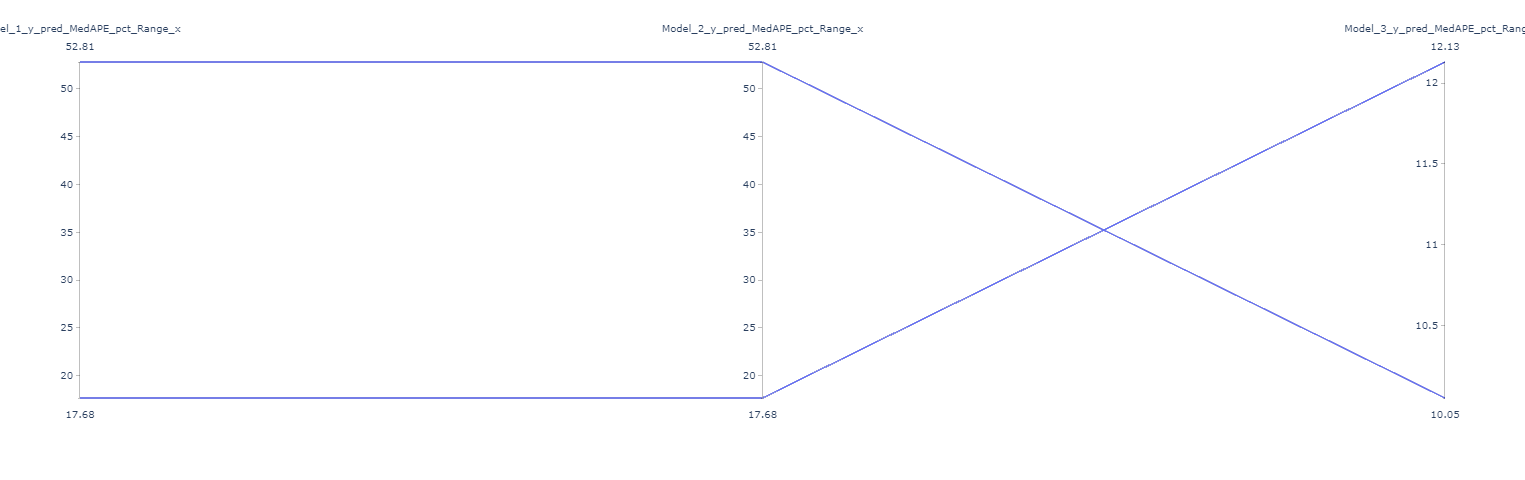

In [88]:

df_pass1 = pd.read_csv('.\\results\\AllResults_FirstPass.csv')
df_pass2 = pd.read_csv('.\\results\\AllResults_SecondPass.csv')

df = df_pass1.merge(df_pass2,how='left',on=['file_name'])
df = df.filter(regex='MedAPE_pct_Range_x')

fig = px.parallel_coordinates(df)

# fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
#                 "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
#                 "petal_width": "Petal Width", "petal_length": "Petal Length", },
#                              color_continuous_scale=px.colors.diverging.Tealrose,
#                              color_continuous_midpoint=2)

fig.show()

In [ ]:
df_results.filter(regex='MedAPE_pct_Range_x')

In [ ]:
df_results.filter(regex='Model_')
df.to_csv('results.csv')

In [ ]:
df_stats = df_stats.merge(df_results,how='right',on=['building','meter'])

In [ ]:
df_stats

In [ ]:
df= df_results.filter(regex='RMSE')
df.head()

In [ ]:
df_stats = df_results.merge(df_stats,how='left',on=['file_name'])

In [ ]:
df_stats.to_csv('AllResults_2_subset.csv',float_format="{:,.2f}".format)

In [ ]:
df_results.filter(regex='RMSE')

In [ ]:
df_results.filter(regex='Model_')
df.to_csv('results.csv')

In [ ]:
df_stats = df_stats.merge(df_results,how='right',on=['building','meter'])

In [ ]:
df_stats

In [ ]:
df= df_results.filter(regex='RMSE')
df.head()

## Time Series Split Cross Validation

In [ ]:
tss =  TimeSeriesSplit(n_splits=4,gap=4,test_size=14,max_train_size=120) #too generic
rmse = []
count = 1

results = pd.DataFrame()


# Write function that rolls next pd.delta?

for train_index, test_index in tss.split(df_train): 
    
    cv_train, cv_test = df_train.iloc[train_index]['meter_reading'], df_train.iloc[test_index]['meter_reading']
    model = pm.auto_arima(cv_train,trace=True,n_fits=20)
    print(model.summary())
    
    # 
    predicts = model.predict(n_periods=14)
    true_values = cv_test.values
    error = ((sqrt(mean_squared_error(predicts,true_values))))
    model.plot_diagnostics()
    rmse.append(error)
    print(error)
print('RMSE')
print(np.mean(rmse))

# Rolling Forecast ARIMA
### Walk-forward validation

In [ ]:
model.plot(forecast)

In [ ]:

#             # Fill Nas
#             #Counts of null values 
#             # Backfill with means
#             if np.max(X_train.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_train_Backfill'] = backfill
#                 if backfill == 'mean':
#                     X_train.fillna(X_train.mean(), inplace=True)

#             # Backfill with mean
#             if np.max(X_test.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     X_test.fillna(X_test.mean(), inplace=True)
                    
#             # Backfill with mean
#             if np.max(y_test.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     y_test.fillna(X_test.mean(), inplace=True)
                    
#             # Backfill with mean
#             if np.max(y_train.isnull().sum().sort_values(ascending=False)) > 0:
#                 stats[model_prefix + '_' + 'X_test_Backfill'] = backfill
#                 if backfill == 'mean':
#                     y_train.fillna(X_train.mean(), inplace=True)